In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf
from IPython.display import Image, HTML, clear_output
import tqdm
import os

CHANNEL_N = 16        # Number of CA state channels
TARGET_SIZE = 32
BATCH_SIZE = 2
POOL_SIZE = 256 # 512 for Colab Pro, 1024 for Colab Pro+
CELL_FIRE_RATE = 0.75

In [2]:
from tensorflow.keras.layers import Conv3D

def to_rgba(x):
    return x[..., :4]

def to_alpha(x):
    return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return 1.0-a+rgb

def get_living_mask(x):
    alpha = x[:, :, :, :, 3:4]
    return tf.nn.max_pool3d(alpha, 3, [1, 1, 1, 1, 1], 'SAME') > 0.1

def make_seed(size, n=1):
    x = np.zeros([n, size, size, CHANNEL_N], np.float32)
    x[:, size//2, size//2, size//2, 3:] = 1.0
    return x

class CAModel3D(tf.keras.Model):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    perc = Conv3D(64, 3, activation=None, groups=self.channel_n, 
                 padding="SAME", use_bias=False, trainable=False)
    
    self.dmodel = tf.keras.Sequential([
          perc,
          Conv3D(160, 1, activation=tf.nn.relu),
          Conv3D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])
    
    self.build((None, 3, 3, 3, channel_n))
        
    identify = np.zeros((3, 3, 3))
    identify[1, 1, 1] = 1
    # 3D Sobel filters
    dx = np.array([1, 2, 1])[None, None, :] * np.outer([1, 2, 1], [-1, 0, 1])[:, :, None] / 32
    dy = np.array([1, 2, 1])[None, None, :] * np.outer([1, 2, 1], [-1, 0, 1]).T[:, :, None] / 32
    dz = (np.array([1, 2, 1])[None, None, :] * np.outer([1, 2, 1], [-1, 0, 1]).T[:, :, None]).T / 32

    kernel = np.stack([identify, dx, dy, dz], -1)[:, :, :, None, :]
    kernel = np.repeat([kernel], repeats=CHANNEL_N, axis=-1)
    perc.set_weights(kernel)
    
    self.dmodel.layers[0].trainable = False

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)
    dx = self.dmodel(x)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel3D().dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 3, 3, 64)       1728      
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 3, 3, 160)      10400     
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 3, 3, 16)       2576      
                                                                 
Total params: 14,704
Trainable params: 12,976
Non-trainable params: 1,728
_________________________________________________________________


In [3]:
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.array(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k).setflags(write=1)
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w, d):
  x = tf.linspace(-1.0, 1.0, w)[None, :, None, None]
  y = tf.linspace(-1.0, 1.0, h)[None, None, :, None]
  z = tf.linspace(-1.0, 1.0, d)[None, None, None, :]
  center = tf.random.uniform([3, n, 1, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1, 1], 0.1, 0.3)
  x, y, z = (x - center[0])/r, (y - center[1])/r, (z - center[2])/r
  mask = tf.cast(x*x+y*y+z*z < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import matplotlib.pyplot as plt

def plot_3d(arr):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    #u = np.moveaxis(arr, (0, 1), (0, 1))
    u=arr
    m = ax.voxels((u[:, :, :, 3] > 0.1), 
                  facecolors=np.clip(u[:, :, :, :4], 0, 1))
    clear_output()
    plt.show()

p = TARGET_SIZE


with open('filter_piece.json','r') as f:
    cat3_data = json.loads(f.read())
vox = np.array(cat3_data)

targets = [vox,vox]

plot_3d(targets[0])


def pad_tgt(tgt):
    px = (p - tgt.shape[0]) // 2
    py = (p - tgt.shape[1]) // 2
    pz = (p - tgt.shape[2]) // 2
    return tf.pad(tgt, [
        (px, px + (p - tgt.shape[0] - 2 * px)), 
        (py, py + (p - tgt.shape[1] - 2 * py)), 
        (pz, pz + (p - tgt.shape[2] - 2 * pz)), (0, 0)])

In [ ]:
pad_targets = [tf.cast(pad_tgt(target_img), tf.float32) 
for target_img in targets]

print(pad_targets[0].shape)
print(pad_targets[1].shape)


#plot_3d(pad_targets[0])
h, w, d = pad_targets[0].shape[:3]
seed = np.zeros([len(targets), h, w, d, CHANNEL_N], np.float32)


# define seed here

seed[0,15,15,15,3:]=1.0
seed[1,15,15,15,3:]=1.0

# show seed
plot_3d(seed[0,:,:,:,:4])
plot_3d(seed[1,:,:,:,:4])

def loss_f(x, target):
    return tf.reduce_mean(tf.square(to_rgba(x) - target), 
                          [-2, -3, -4, -1])

ca = CAModel3D()
loss_log = []

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed[0], pad_targets[0]).numpy()

inp = tf.cast(np.repeat(seed, POOL_SIZE//len(targets), 0), tf.float32)
tgt = tf.repeat(pad_targets, POOL_SIZE//len(targets), 0)

pool = SamplePool(x=inp, y=tgt)

#plot_3d(np.array(pad_targets[1]))


# Training

In [ ]:
def batch_3d_viz(x, x0):
    fig = plt.figure(figsize=plt.figaspect(0.35)*1.5)
    ax = [fig.add_subplot(2, BATCH_SIZE, i, projection='3d') 
          for i in range(1, 2 * BATCH_SIZE + 1)]
    for i in range(BATCH_SIZE):
        u = np.moveaxis(x0[i], (0, 1), (0, 1))
        ax[i].set_axis_off()
        ax[i].voxels((u[:, :, :, 3] > 0.1), 
                     facecolors=np.clip(u[:, :, :, :4], 0, 1))
    for i in range(BATCH_SIZE):
        u = np.moveaxis(x[i].numpy(), (0, 1), (0, 1))
        ax[BATCH_SIZE + i].set_axis_off()
        ax[BATCH_SIZE + i].voxels((u[:, :, :, 3] > 0.1), 
                                  facecolors=np.clip(u[:, :, :, :4], 0, 1))


Training

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

@tf.function
def train_step(x, y):
    iter_n = tf.random.uniform([], 64, 96, tf.int32)
    with tf.GradientTape() as g:
        for i in tf.range(iter_n):
            x = ca(x)
        loss = tf.reduce_mean(loss_f(x, y))
    grads = g.gradient(loss, ca.weights)
    grads = [g/(tf.norm(g)+1e-8) for g in grads]
    # Hack to not train the first layer (Sobel filters)
    # because apparently setting .trainable = False isn't enough
    trainer.apply_gradients(zip(grads[1:], ca.weights[1:])) 
    return x, y, loss

# ca.save_weights('./catheadtest.h5')

for i in range(5000):
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    y0 = batch.y
    # print(x0.shape) == (4, 32, 32, 32, 16)
    # print(y0.shape) == (4, 32, 32, 32, 4)

    loss_rank = loss_f(x0, y0).numpy().argsort()[::-1]
    
    # print(loss_rank.shape) == (4,) might be the loss of 4 targets
    
    
    x0 = x0[loss_rank]
    y0 = y0[loss_rank]
    # print(x0.shape) == (4, 32, 32, 32, 16)
    # print(y0.shape) == (4, 32, 32, 32, 4)

    simple = np.random.choice(range(len(targets)), size=2) # two random number in targets

    # print(x0[:2].shape) == (2, 32, 32, 32, 16)
    # print(seed[simple].shape) == (2, 32, 32, 32, 16)
    x0[:2] = seed[simple]
    
    # remained to be figure out
    for n, u in enumerate(simple):  
        y0[n] = pad_targets[u]
        
        
    # print(x0.shape) == (4, 32, 32, 32, 16)
    # print(y0.shape) == (4, 32, 32, 32, 4)

    
    x, y, loss = train_step(x0, y0)
    
    # print(x.shape) == (4, 32, 32, 32, 16)
    # print(y.shape) == (4, 32, 32, 32, 4)

    step_i = len(loss_log)
    loss_log.append(loss.numpy())
    #batch_3d_viz(x, x0)

    if step_i%100 == 0:
      clear_output()
      plot_loss(loss_log)
      #export_model(ca, 'train_log/%04d'%step_i)
      # plot_3d(np.array(x[0,:,:,:,:4]))
      # plot_3d(np.array(x[1,:,:,:,:4]))
      # batch_3d_viz(x, x0)
      

    if step_i%200 == 0:
      batch_3d_viz(x, x0)
      ca.save_weights('./drive/MyDrive/filter_piece.h5')
      pass
    

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), 
                                            np.log10(loss)), end='')
    
    
ca.save_weights('./filter_piecce.h5')

Read from trained models

In [4]:
import json
import matplotlib.pyplot as plt
def plot_3d(arr,i):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    u = np.moveaxis(arr, (0, 1), (0, 1))
    m = ax.voxels((u[:, :, :, 3] > 0.1), facecolors=np.clip(u[:, :, :, :4], 0, 1))
    clear_output()
    plt.show()
    plt.close()

new_model = CAModel3D()
new_model.load_weights('./filter_piece.h5')


s=32
h=s
w=s
d=s

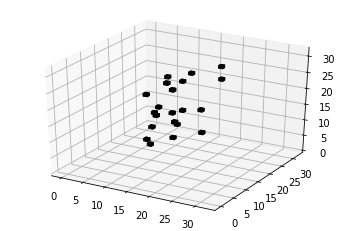

In [5]:
# define seed here
from random import randint

seed = np.zeros([4, s, s, s, 16])
seed[0, h//2, w//2 , d//2, 3:] = 1.0

for i in range(20):
  seed[0,randint(7,22),randint(3,28),randint(3,28),3:]=1.0

plot_3d(seed[0],0)

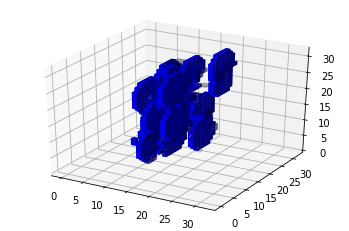

In [6]:
seed=new_model(seed)

# loop to output json file
for i in range(56):
  print(i)
  seed = new_model(seed)
  plot_3d(seed[0],i)


In [27]:
with open('output.json','w') as f:
  data = json.dumps(seed[0].numpy().tolist())
  f.write(data)

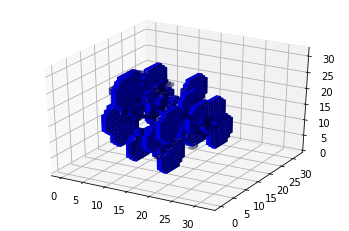

In [27]:
with open('filter_rand20.json','r') as f:
  data=json.loads(f.read())
a=np.array(data)
plot_3d(a,0)

In [ ]:
new_model = CAModel3D()
new_model.load_weights('drive/MyDrive/hytest_doubleseed.h5')
import matplotlib.pyplot as plt

def plot_3d(arr,i):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    u = np.moveaxis(arr, (0, 1), (0, 1))
    m = ax.voxels((u[:, :, :, 3] > 0.1), facecolors=np.clip(u[:, :, :, :4], 0, 1))
    plt.savefig('./fig/'+str(i)+'.png')
    clear_output()
    plt.show()

# with open('drive/Mydrive/cat3.json','r') as f:
#     cat3_data = json.loads(f.read())
# cat3 = np.array(cat3_data)

# #plot_3d(cat3,0)

# print(cat3.shape)
# print(seed[0].shape)

s=32
h=s
w=s
d=s
seed = np.zeros([4, s, s, s, 16])



# defind seed down here


seed[0, 15, 12, 11, 3:] = 1.0
seed[0, 15, 13, 11, 3:] = 1.0
seed[0, 15, 14, 11, 3:] = 1.0
seed[0, 15, 15, 11, 3:] = 1.0
seed[0, 15, 16, 11, 3:] = 1.0

seed[0, 15, 12, 18, 3:] = 1.0
seed[0, 15, 13, 18, 3:] = 1.0
seed[0, 15, 14, 18, 3:] = 1.0
seed[0, 15, 15, 18, 3:] = 1.0
seed[0, 15, 16, 18, 3:] = 1.0



seed=new_model(seed)
plot_3d(seed[0],0)

for i in range(95):
  print(i)
  seed = new_model(seed)
  #print(seed[0])
  plot_3d(seed[0],i)

# with open('output.json','w') as f:
#   data = json.dumps(seed[0].numpy().tolist())
#   f.write(data)

Gif Generator

In [ ]:
import imageio
from pathlib import Path


def imgs2gif(imgPaths, saveName, duration=None, loop=0, fps=None):
    """
    :param duration: gap between frames. counted in second
    :param loop: 播放次数（在不同的播放器上有所区别）， 0代表循环播放
    :return:
    """
    if fps:
        duration = 1 / fps
    images = [imageio.imread(str(img_path)) for img_path in imgPaths]
    imageio.mimsave(saveName, images, "gif", duration=duration, loop=loop)


# pathlist = Path(r"G:\img").glob("*.jpg")

p_lis = []
for i in range(95):
  p_lis.append('./fig/'+str(i)+'.png')

# for n, p in enumerate(pathlist):
#     if n % 5 == 0:
#         p_lis.append(p)

imgs2gif(p_lis, "output.gif", 0)